# XGBoost for classification of malware

<b>Author</b>: Chan, Chun-Hsiang (<b>TooDou</b>) @ D04228002 NTU GEOG

<div align="justify">
<b>Brief Introduction</b><br />
In this report, we would like to use xgboost classification as classification approach to classify the different types of malwares. Also we tried different parameters to know which one is the best of all through the function GridSearchCV. In addition, we applied the heat map to show the confusion matrix in figure.
</div>

In [34]:
# import the packages
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [3]:
# Load the data
train_df = pd.read_csv('LargeTrain.csv', header=0)
test_df = pd.read_csv('LargeTest.csv', header=0)

In [4]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

feature_columns_to_use = ['Pclass','Sex','Age','Fare','Parch']
nonnumeric_columns = []

In [5]:
# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
# big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X = train_df.append(test_df)
big_X_imputed = DataFrameImputer().fit_transform(big_X)

In [6]:
# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [7]:
# Prepare the inputs for the model
train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
test_X = big_X_imputed[train_df.shape[0]::].as_matrix()
train_y = train_df['Class']

In [8]:
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
predictions = gbm.predict(test_X)

In [9]:
# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.
submission = pd.DataFrame({ 'PassengerId': test_df['Virtual'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

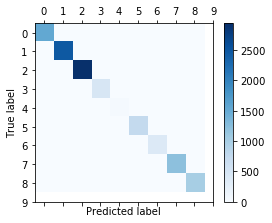

In [36]:
# plot the heat map of confusion matrix
pred = gbm.predict(train_X)

plt.matshow(confusion_matrix(train_y, pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [15]:
# import packages
from sklearn.model_selection import GridSearchCV

In [19]:
# GridSearchCV for n_estimators of xgboost 
grid = GridSearchCV(gbm,
                    param_grid={'n_estimators' : [100,150,200]})
grid.fit(train_X, train_y)
print(grid.best_params_)

{'n_estimators': 200}


In [20]:
# GridSearchCV for learning rate of xgboost 
gridlr = GridSearchCV(gbm,
                    param_grid={'learning_rate' : [0.02,0.05,0.08]})
gridlr.fit(train_X, train_y)
print(gridlr.best_params_)

{'learning_rate': 0.05}


In [41]:
# set x values for plotting
ne = [100,150,200]
lr = [0.02, 0.05, 0.08]

In [45]:
# show the accuracy of n_estimators
grid.cv_results_['mean_test_score']

array([ 0.99917188,  0.99963195,  0.99981597])

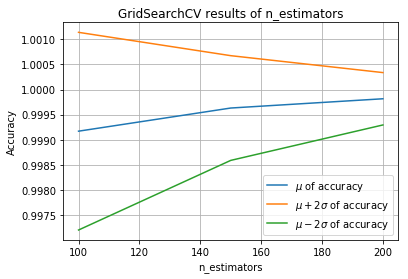

In [55]:
# plot the GridSearchCV results of n_estimators
plt.plot(ne,grid.cv_results_['mean_test_score'])
plt.plot(ne,grid.cv_results_['mean_test_score']+2*grid.cv_results_['std_test_score'])
plt.plot(ne,grid.cv_results_['mean_test_score']-2*grid.cv_results_['std_test_score'])
plt.title('GridSearchCV results of n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(['$\mu$ of accuracy','$\mu+2\sigma$ of accuracy','$\mu-2\sigma$ of accuracy'])
plt.grid(True)
plt.show()

In [54]:
# show the accuracy of learning rate
gridlr.cv_results_['mean_test_score']

array([ 0.99944792,  0.99963195,  0.99963195])

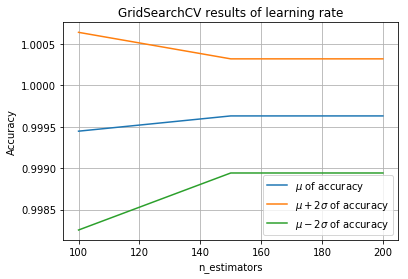

In [53]:
# plot the GridSearchCV results of learning rate
plt.plot(ne,gridlr.cv_results_['mean_test_score'])
plt.plot(ne,gridlr.cv_results_['mean_test_score']+2*gridlr.cv_results_['std_test_score'])
plt.plot(ne,gridlr.cv_results_['mean_test_score']-2*gridlr.cv_results_['std_test_score'])
plt.title('GridSearchCV results of learning rate')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(['$\mu$ of accuracy','$\mu+2\sigma$ of accuracy','$\mu-2\sigma$ of accuracy'])
plt.grid(True)
plt.show()

In [59]:
# predict by model of the best value of n_estimators
x_pred_ne = grid.predict(train_X)

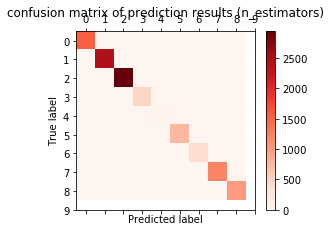

In [62]:
# plot the confusion matrix of prediction results (n_estimators)
plt.matshow(confusion_matrix(train_y, x_pred_ne), cmap="Reds")
plt.colorbar(shrink=0.8)
plt.title('confusion matrix of prediction results (n_estimators)')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [64]:
# predict by model of the best value of n_estimators
x_pred_lr = gridlr.predict(train_X)

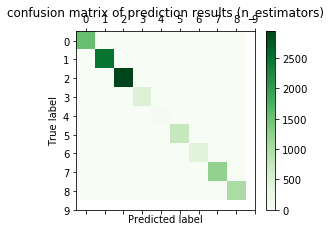

In [65]:
# plot the confusion matrix of prediction results (n_estimators)
plt.matshow(confusion_matrix(train_y, x_pred_lr), cmap="Greens")
plt.colorbar(shrink=0.8)
plt.title('confusion matrix of prediction results (n_estimators)')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()